In [11]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import plots
import functions
import glob
import os
from shapely.geometry import LineString, Point
import geopandas as gpd    
from pyproj import Geod
from matplotlib.animation import FuncAnimation

In [13]:
bathy = xr.open_dataset('GEBCO_14_May_2025_b03991ce039e/gebco_2024_n75.0_s42.0_w-80.0_e-40.0.nc') 

In [15]:
GriddedData = xr.open_dataset('GriddedData/gridded_swot_timeseries.nc')
GriddedData = GriddedData.sortby('time')
GriddedData.load()

<xarray.Dataset>
Dimensions:  (time: 652, lat: 402, lon: 175)
Coordinates:
  * time     (time) datetime64[ns] 2023-07-27T09:41:49.793235456 ... 2025-08-...
  * lat      (lat) float64 45.0 45.02 45.04 45.07 ... 53.94 53.96 53.98 54.01
  * lon      (lon) float64 -56.0 -55.97 -55.93 -55.9 ... -50.05 -50.02 -49.98
Data variables:
    ssh      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ugeos    (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    vgeos    (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [17]:
Line_strings = [LineString([(-55.6508, 53.3127),
                    (-53.8696, 53.8646)]), 
         LineString([ (-53.8696, 53.8646), 
                    (-50.2795,46.7089)]),
          LineString([(-50.2795,46.7089),
                    (-51.8235,45.8096)]), 
           LineString([(-51.8235,45.8096),
                   (-53.1607,46.5873)]) ]

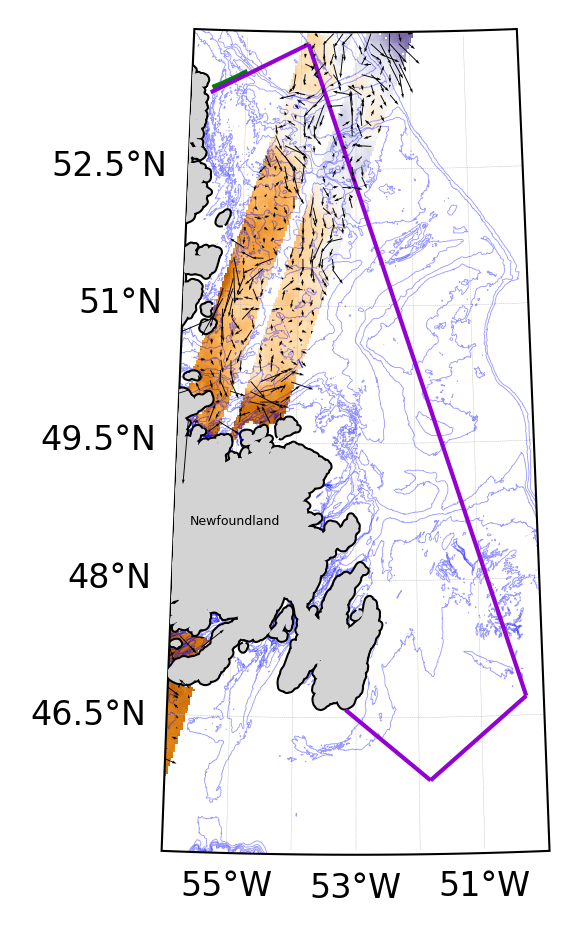

In [19]:
fig, ax, rect = plots.figure(figsize=(3, 3),nrows=1,ncols=1,region=[-56, -50, 45, 54])

plots.axis_shape(ax, rect, addCoastline=True, addCheckerboard=False)

BC2 = (-1*bathy.elevation).plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='blue', alpha=0.4,levels=[150,200,250,300,400,500], 
                                       linewidths=0.2, zorder=2)

ax.text(-55, 48.6, "Newfoundland",transform=ccrs.PlateCarree(), horizontalalignment='center', fontsize=3)
x=[-55.03333, -55.16233, -55.43833, -55.56367]
y=[53.53333,  53.491, 53.40833, 53.37517]
lcc = ax.plot(x,y, 'g', label='LCC moorings', transform=ccrs.PlateCarree(), zorder=3)[0]

# mo1 = ax.plot(-53.00083, 50.74967, 'o', c='b', label='SWOT1-01', markersize=3, transform=ccrs.PlateCarree(), zorder=3)[0]  # position of mooring 1
# mo2 = ax.plot(-53.26417, 50.16467, 'o', c='fuchsia', label='SWOT2-01', markersize=3, transform=ccrs.PlateCarree(), zorder=3)[0]  # position of mooring 2
# mo3 = ax.plot(-52.58427, 49.74992, 'o', c='cyan', label='SWOT3-01', markersize=3, transform=ccrs.PlateCarree(), zorder=3)[0]  # position of mooring 3

gdf = gpd.GeoDataFrame(geometry= Line_strings)

gdf.plot(ax=ax, color='darkviolet', linewidth=1, transform=ccrs.PlateCarree(), zorder=3)

t0 = 0
ssh0 = GriddedData.ssh.isel(time=t0)

p = ax.pcolormesh(
    GriddedData.lon, GriddedData.lat, ssh0,
    cmap="PuOr_r", vmin=-0.5, vmax=0.1,
    transform=ccrs.PlateCarree(), zorder=1
)

step = 5
quiv = ax.quiver(
    GriddedData.lon[::step].values,
    GriddedData.lat[::step].values,
    GriddedData.ugeos.isel(time=t0)[::step, ::step].values,
    GriddedData.vgeos.isel(time=t0)[::step, ::step].values,
    transform=ccrs.PlateCarree(),
    scale=6, color="k", zorder=3
)

def update(frame):
    ssh_t = GriddedData.ssh.isel(time=frame)
    p.set_array(ssh_t.values.ravel())  
    
    u = GriddedData.ugeos.isel(time=frame)[::step, ::step].values
    v = GriddedData.vgeos.isel(time=frame)[::step, ::step].values
    quiv.set_UVC(u, v)  
    

    ts = str(GriddedData.time.values[frame])[:16]
    ax.set_title(f"SSH and Velocity currents — {ts}", fontsize=6)
    
    return [p, quiv]

frame_stride = 1
frames = range(0, len(sorted(GriddedData.time)), frame_stride)
anim = FuncAnimation(fig, update, frames=frames, interval=200, blit=False)

plt.show()

# Save as mp4 (ffmpeg required)
# anim.save("currents_animation.mp4",writer='ffmpeg', dpi=300)